In [23]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns


In [24]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging

In [25]:
# reading the dataset
df = pd.read_csv("public/data_source/rca.csv")
actualData = pd.read_csv("public/data_source/ret_info.csv")

In [26]:
def getConfusionMatrix(actual, predicted):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    #print(confusion_matrix)

In [27]:
#df.plot.scatter('latency', 'source')

In [28]:
le = preprocessing.LabelEncoder()
le.fit(df['source'])
LabelEncoder()
list(le.classes_)
sourceTransformed = le.transform(df['source'])

In [29]:
X1 = df['latency'].values.reshape(-1,1)
X2 = sourceTransformed.reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)

In [30]:
outliers_fraction = 0.1
# Test 4 different methods
classifiers = {
        'FeatureBagging': FeatureBagging(contamination=outliers_fraction),
        'KNN': KNN(contamination=outliers_fraction),
        'HBOS': HBOS(contamination=outliers_fraction),
        'IForest': IForest(contamination=outliers_fraction)
}

In [31]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
plt.figure(figsize=(10, 10))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)

    np.unique(y_pred, return_counts=True)

    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)

    print('\n\nOUTLIERS : ', n_outliers, 'INLIERS : ', n_inliers, clf_name)

    outliers = []
    for index in range(len(y_pred)):        
        if y_pred[index] == 1:
            outliers.append(index)

    # print(outliers)

    outliersList = df.iloc[outliers, :]
    print(outliersList.head(10))

    #getConfusionMatrix(y_pred)

    #pd.DataFrame(outliersList).to_csv("public/results/"+clf_name+"_preresult.csv")



    # threshold value to consider a datapoint inlier or outlier - the probability that the prediction is true
#    threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
#    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
#    Z = Z.reshape(xx.shape)

    # plot outliers and contour
#    subplot = plt .subplot(2, 2, i + 1)
#    subplot.contour(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 15))
#    subplot.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
#    subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')

    # scatter plot of inliers with white dots
#    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1],c='white', s=12, edgecolor='g')
    # scatter plot of outliers with black dots
#    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1],c='black', s=12, edgecolor='g')
#    subplot.axis('tight')

#    subplot.set_title(clf_name)
#    subplot.set_xlim((-15, 15))
#    subplot.set_ylim((-15, 15))

#plt.show()





OUTLIERS :  195 INLIERS :  1905 FeatureBagging
                trace_id     timestamp  latency  succ      source      target
0   868d91717444d4112006  1.587400e+12        4  True  docker_005      db_003
3   868d91717444d4112006  1.587400e+12       40  True  docker_004  docker_005
15  868d91717444d4112006  1.587400e+12        1  True  docker_005      db_003
54  868d91717444d4112006  1.587400e+12        7  True  docker_004  docker_004
55  868d91717444d4112006  1.587400e+12       26  True      os_021  docker_004
60  2190e1717444d4129924  1.587400e+12        1  True  docker_007  docker_007
61  2190e1717444d4129924  1.587400e+12       41  True  docker_001  docker_007
73  2190e1717444d4129924  1.587400e+12        1  True  docker_007      db_003
79  2190e1717444d4129924  1.587400e+12        4  True  docker_008  docker_008
86  2190e1717444d4129924  1.587400e+12        4  True  docker_001  docker_001


OUTLIERS :  98 INLIERS :  2002 KNN
                 trace_id     timestamp  latency  succ  

<Figure size 720x720 with 0 Axes>



actual
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 

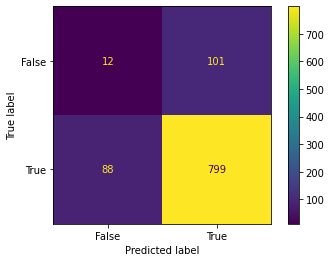

In [33]:

actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)

print("\n\nactual\n",actual)
print("\n\npredicted\n",predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()
